In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from src.data_loading import get_resnet_transforms
from PIL import Image

%matplotlib inline


train_dir = './data/train/train'
test_dir = './data/test/test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy() 
            return img.astype('float32'), self.file_list[idx]
        
data_transform = get_resnet_transforms()

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=4)


# samples, labels = iter(dataloader).next()
# plt.figure(figsize=(16,24))
# grid_imgs = torchvision.utils.make_grid(samples[:24])
# np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
# plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))



/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ray/miniconda3/envs/learning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1/3] Iteration 200 -> Train Loss: 0.7111, Accuracy: 0.688
[Epoch 1/3] Iteration 400 -> Train Loss: 0.5400, Accuracy: 0.719
[Epoch 1/3] Iteration 600 -> Train Loss: 0.4279, Accuracy: 0.875
[Epoch 2/3] Iteration 800 -> Train Loss: 0.3108, Accuracy: 0.875
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.2758, Accuracy: 0.844
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.2153, Accuracy: 0.906
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1852, Accuracy: 0.969
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1837, Accuracy: 1.000
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.1513, Accuracy: 1.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.1465, Accuracy: 1.000
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.1471, Accuracy: 0.875
model ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1,

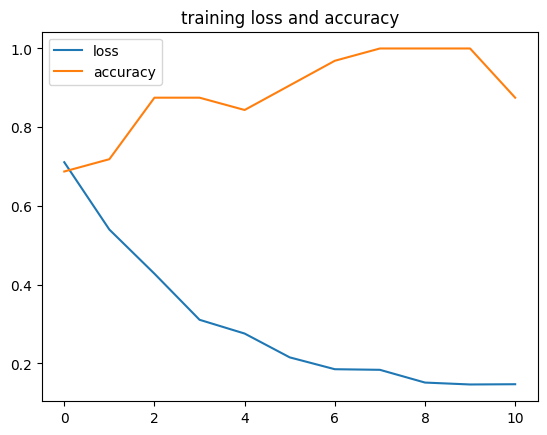

In [2]:


# transfer learning

device = 'cuda'
#  model = torchvision.models.densenet121(pretrained=True)
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Sequential(
#    nn.Linear(num_ftrs, 500),
#    nn.Linear(500, 2)
#)
model = torchvision.models.resnet50(pretrained=True)
    
num_ftrs = model.fc.in_features
n_classes = 2
model.fc = nn.Linear(num_ftrs, n_classes)
model.to(device)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

import os
#  create directory cheeckpoints if does not exist
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
filename_pth = os.path.join('checkpoints', 'resnet50.pth')
print(f"model {model}")
torch.save(model.state_dict(), filename_pth)

acc_list = [i.cpu().numpy() for i in acc_list]
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()